There is no inbuilt plotting API in Spark. Here I use matplotlib to make plots. But we have to be very careful to use them. Usually Spark is meant to handle large data which can not fit into memory. Python plot library requires all the data loaded in momory before making any plots. But we can be careful here and do the calculation beforehand and feed them in matplotlib. For example from data with billions of rows and hundreds of columns if we are interested to make bar plot of top 10 values of one feature, we can select the top 10 value of that feature from spark query and feed that in matplotlib. In this way the heavy lifting is done by spark and allow matplotlib to handle few 10s to processed data. 

The plot functions presented below are designed carefully for the case basis. I tried to generalize it to some extent but I don't claim them to be general. But it gives you the idea what can be or should be done to generate visualization from Spark. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName('Name').config('config_option', 'value').getOrCreate()

In [10]:
df = spark.read.option('inferSchema', True).csv('Life_Expectancy.csv', header=True)
df.show(2)

+-----------+----+----------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+----------+-----------+---------------------+-------------------+-------------------------------+---------+
|    Country|Year|    Status|Life expectancy |Adult Mortality|infant deaths|Alcohol|percentage expenditure|Hepatitis B|Measles | BMI |under-five deaths |Polio|Total expenditure|Diphtheria | HIV/AIDS|       GDP| Population| thinness  1-19 years| thinness 5-9 years|Income composition of resources|Schooling|
+-----------+----+----------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+----------+-----------+---------------------+-------------------+-------------------------------+---------+
|Afghanistan|2015|Developing|            65.0|            263|           62|   

In [11]:
# Tabular visualization

# Pandas was better! But we can convert Spark dataframe into
# pandas dataframe. But since we just want to see the top few 
# rows it makes sense to convert only top rows of the Spark 
# dataframe to Pandas. It saves the computer memory consumption. 
# Usually Spark dataframe is meant to handle really large data. 

In [12]:
df.limit(5).toPandas()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263,62,0.01,71.279624,65,1154,...,6,8.16,65,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271,64,0.01,73.523582,62,492,...,58,8.18,62,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268,66,0.01,73.219243,64,430,...,62,8.13,64,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272,69,0.01,78.184215,67,2787,...,67,8.52,67,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275,71,0.01,7.097109,68,3013,...,68,7.87,68,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [13]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Life expectancy : double (nullable = true)
 |-- Adult Mortality: integer (nullable = true)
 |-- infant deaths: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- percentage expenditure: double (nullable = true)
 |-- Hepatitis B: integer (nullable = true)
 |-- Measles : integer (nullable = true)
 |--  BMI : double (nullable = true)
 |-- under-five deaths : integer (nullable = true)
 |-- Polio: integer (nullable = true)
 |-- Total expenditure: double (nullable = true)
 |-- Diphtheria : integer (nullable = true)
 |--  HIV/AIDS: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Population: double (nullable = true)
 |--  thinness  1-19 years: double (nullable = true)
 |--  thinness 5-9 years: double (nullable = true)
 |-- Income composition of resources: double (nullable = true)
 |-- Schooling: double (nullable = true)



In [14]:
df = df.select('Country', 'Year', 'Alcohol', 'GDP', 'Population')

In [15]:
df.show(3)

+-----------+----+-------+----------+-----------+
|    Country|Year|Alcohol|       GDP| Population|
+-----------+----+-------+----------+-----------+
|Afghanistan|2015|   0.01| 584.25921|3.3736494E7|
|Afghanistan|2014|   0.01|612.696514|   327582.0|
|Afghanistan|2013|   0.01|631.744976|3.1731688E7|
+-----------+----+-------+----------+-----------+
only showing top 3 rows



In [16]:
# Histogram 

# This might be the easiest of all. Spark RDDs has .histogram() 
# method which gives histogram values for specified number of bins. 
# We just need to plot these bins in python. 

In [20]:
def histogram(df, col, bins=10, xname=None, yname=None):
    
    '''
    This function makes a histogram from spark dataframe named 
    df for column name col. 
    '''
    
    # Calculating histogram in Spark 
    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)
    
    # Preprocessing histogram points and locations 
    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]
    
    # Making a bar plot 
    plt.bar(loc, vals[1], width=width)
    plt.xlabel(col)
    plt.ylabel(yname)
    plt.show()

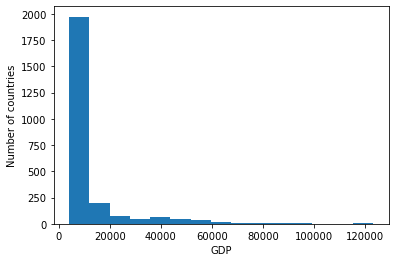

In [22]:
# Plotting the GDP histogram 
# There are a lots of lots of very very poor country. 
# The world is skewwwwwwwd!

histogram(df, 'GDP', bins=15, yname='Number of countries')

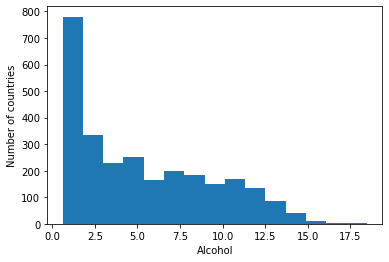

In [23]:
histogram(df, 'Alcohol', bins=15, yname='Number of countries')

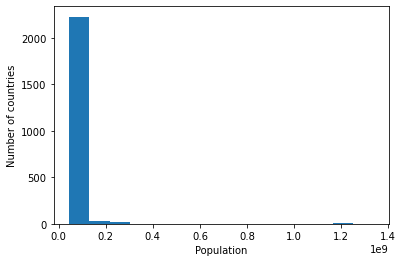

In [45]:
histogram(df, 'Population', bins=15, yname='Number of countries')

In [34]:
df.select('Population').summary().show()

+-------+--------------------+
|summary|          Population|
+-------+--------------------+
|  count|                2286|
|   mean|1.2753375120052498E7|
| stddev| 6.101209650842794E7|
|    min|                34.0|
|    25%|            195553.0|
|    50%|           1384969.0|
|    75%|           7423289.0|
|    max|       1.293859294E9|
+-------+--------------------+



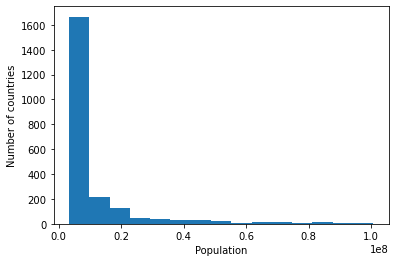

In [43]:
histogram(df.filter(df['Population']<100000000), \
          'Population', bins=15, yname='Number of countries')

In [46]:
# Line plot 

# This type of plots are usually represented for the time series. 
# Sometimes distribution functions are also represented as line plot. 
# First we group by the data in time (or on the variable of which 
# distribution is of interest) and then we apply some sort of averaging 
# on the grouped data. I have included few averaging in my implemantation. 
# Others can be added similarly or can be done manually outside funtion. 

In [47]:
def lineplot(df, x, y, measure='mean'):
    
    '''
    This function makes a line plot from Spark dataframe df with 
    independent variable x and averaged over y.
    '''
    
    if measure == 'mean':
        
        # Grouping the dataframe by x and averaging over y
        # Sorting is important because Spark shuffle the values 
        # when doing the calculation
        
        pd_df = df.groupBy(x).mean(y).toPandas().sort_values(by=x)
        
        # Making plot using pandas 
        pd_df.plot(x, 'avg({})'.format(y), legend=False)
        
    elif measure == 'total':
        pd_df = df.groupBy(x).sum(y).toPandas().sort_values(by=x)
        pd_df.plot(x, 'sum({})'.format(y), legend=False)
        
    elif measure == 'count':
        pd_df = df.groupBy(x).count().toPandas().sort_values(by=x)
        pd_df.plot(x, 'count', legend=False)
    
    plt.ylabel(y)
    plt.show()

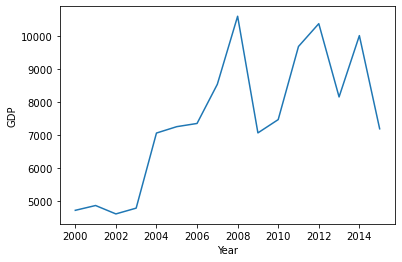

In [66]:
lineplot(df, 'Year', 'GDP', measure='mean')

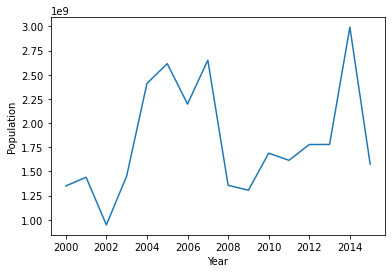

In [50]:
lineplot(df, 'Year', 'Population', measure='total')

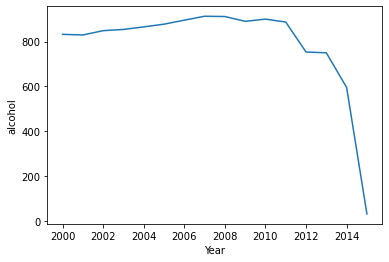

In [65]:
# The world has become no alcoholic all of sudden??!

lineplot(df, 'Year', 'alcohol', measure='total')

In [54]:
# Bar plot 

# In bar plot usually we are interested on top few entries 
# if thre are many. For this we can order the dataframe to 
# get the top entries on top. Then we limit the number of 
# entries, which is also the number of bars we want to see in 
# the plot, before converting it to the pandas datafrmae. 

In [55]:
def barplot(df, col, lim=10, yname=None):
    
    '''
    This function makes a bar plot for the Spark dataframe df 
    for categorical column col only selecting top categories 
    as specified by lim. 
    '''
    
    # Grouping by the categories, counting on each categories 
    # and ordering them by the count
    classes = df.groupBy(col).count().orderBy('count', ascending=False)
    
    # Take first 'lim' number of rows and convert to pandas  
    pd_df = classes.limit(lim).toPandas()
    
    # Making plot 
    pd_df.plot(kind='bar', x=col, legend=False)
    plt.ylabel(yname)
    plt.show()

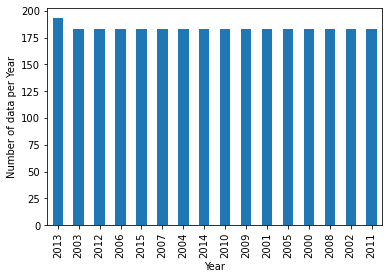

In [69]:
# Everybody is participating every year (almost)

barplot(df, 'Year', lim=20, yname='Number of data per Year')

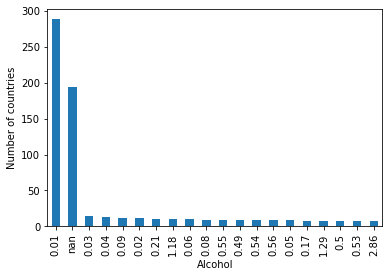

In [58]:
# Most of the world population consumes very little alcohol. 

barplot(df, 'Alcohol', lim=20, yname='Number of countries')

# Which country has the largest population?
# Which country has the largest GDP?

In [15]:
# Pie chart 

# Idea of bar chart is exactly similar to the bar plot 
# Just replace bar plot at the end by pir chart. 

In [70]:
def pieplot(df, col, lim=10, yname=None):
    
    '''
    This function makes a pie chart for the Spark dataframe df 
    for categorical column col only selecting top categories 
    as specified by lim. 
    '''
    
    # Grouping by the categories, counting on each categories 
    # and ordering them by the count
    classes = df.groupBy(col).count().orderBy('count', ascending=False)
    
    # Take first 'lim' number of rows and convert to pandas  
    pd_df = classes.limit(lim).toPandas()
    
    # Making plot 
    pd_df.plot(kind='pie', x=col, y='count', \
           labels=pd_df[col], legend=False)
    plt.ylabel(None)
    plt.show()

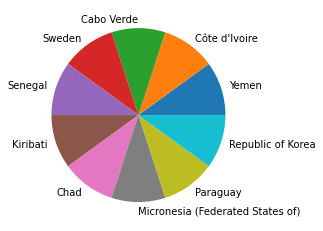

In [71]:
pieplot(df, 'Country')

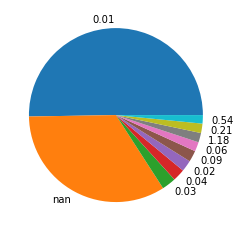

In [73]:
pieplot(df, 'Alcohol')

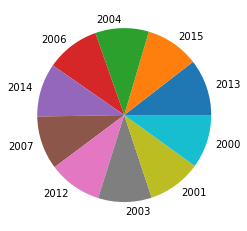

In [77]:
pieplot(df, 'Year')

In [18]:
# Box plot 

# Box plot can be computationally very heavy. Usually it takes all 
# the data, calculates the quartiles and also indicates the outlier. 
# It could be done easier if we ignore the outlier part. 
# However, outliers are import part of box plot. So, I choose sampling 
# method. I choose a fraction of sample of the total data and make a 
# Box plot out of that. 

# An alternative approach could be using quartiles and outliers which 
# is not done here. 

In [74]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [75]:
def boxplot(df, col, group_by, samp_size=10000): 
    
    '''
    This function makes a box plot for a Spark dataframe df 
    grouping them by a column name called group_by and their
    aggrigate on another column called col. 
    '''
    
    # Selecting sample for the large dataset 
    # For samll data sampling is not done. For the large data 
    # sample size is the specified number. 
    
    true_samp_size = min(samp_size/df.count(), 1.0)
    pd_df = df.sample(False, true_samp_size).toPandas()
    
    # Making plot 
    pd_df.boxplot(col, by=group_by, figsize=(8, 5))
    plt.ylabel(col)
#     plt.xticks([2000, 2005, 2010, 2015])
    plt.title(None)
    plt.show()

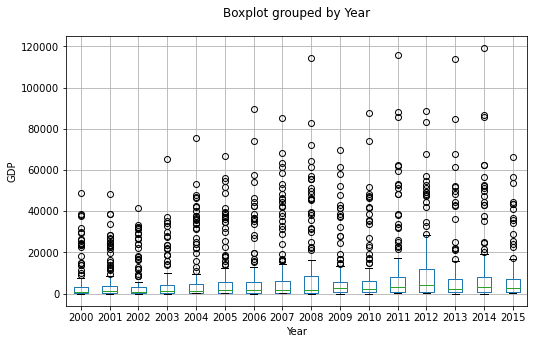

In [76]:
# The rich countries are outliers in our world. 
# Being poor is the norm. 

boxplot(df, 'GDP', 'Year')

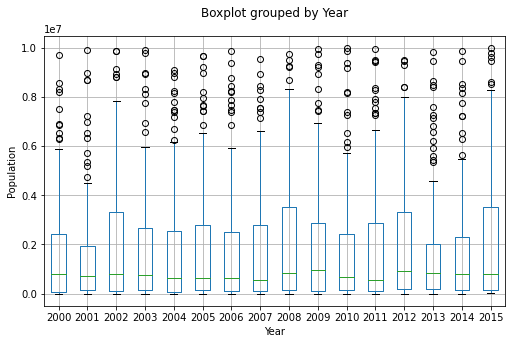

In [81]:
boxplot(df.filter(df['Population']<10000000), 'Population', 'Year')